## Outlier Detection

In [98]:
from os import path
import pandas as pd

### Cyclists' outlier detection

In [99]:
datasetname = path.join('..', 'dataset', 'cyclists_final_enhanced.csv')
cyclists = pd.read_csv(datasetname)
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _url                    6134 non-null   object 
 1   name                    6134 non-null   object 
 2   birth_year              6134 non-null   int64  
 3   weight                  6134 non-null   float64
 4   height                  6134 non-null   int64  
 5   nationality             6134 non-null   object 
 6   bmi                     6134 non-null   float64
 7   career_points           6134 non-null   float64
 8   career_duration(days)   6134 non-null   float64
 9   career_duration(races)  6134 non-null   float64
 10  debut_year              6134 non-null   float64
 11  avg_pos                 6134 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 575.2+ KB


For the cyclists we use the following features:
- `weight`: the weight of the cyclist 
- `height`: the height of the cyclist
- `birth_year`: the birth year of the cyclist
- `bmi`: the body mass index of the cyclist
- `career_points`: the career points of the cyclist           
- `career_duration(days)`: the career duration of the cyclist in days   
- `career_duration(races)`: the career duration of the cyclist in years  
- `debut_year`: the first year where the cyclist competed              
- `avg_pos`: the average position of the cyclist                 

In [100]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['weight']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

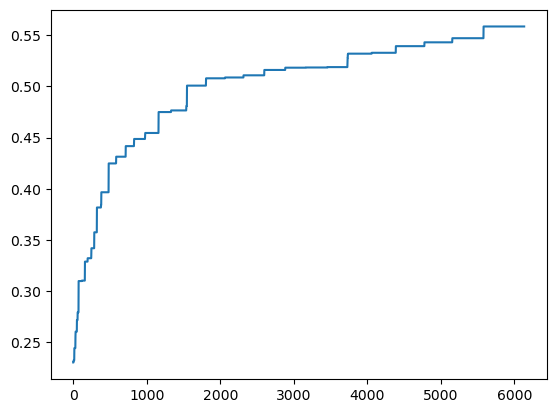

In [101]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [102]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['height']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

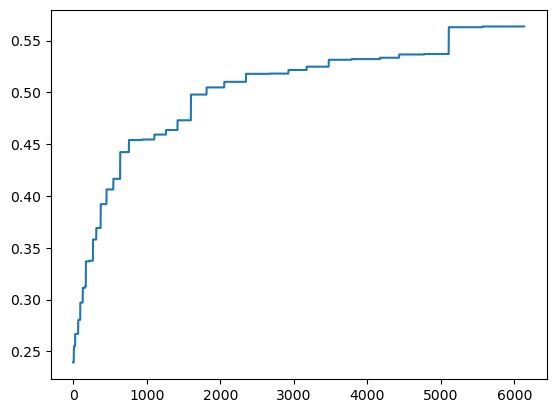

In [103]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [104]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['birth_year']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

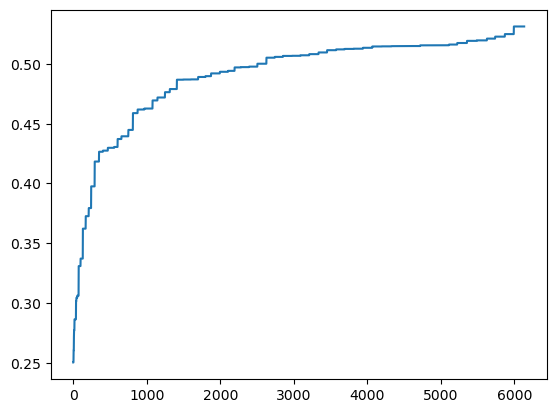

In [105]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [106]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['bmi']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

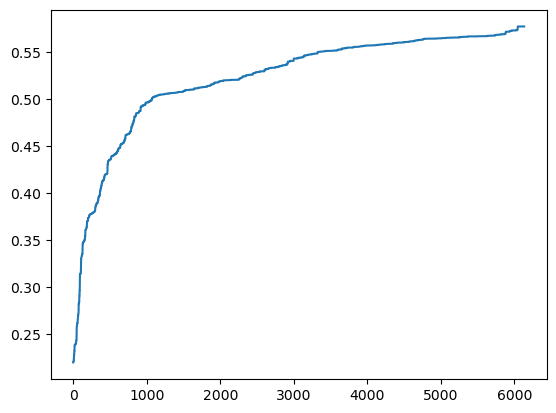

In [107]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [108]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['career_points']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

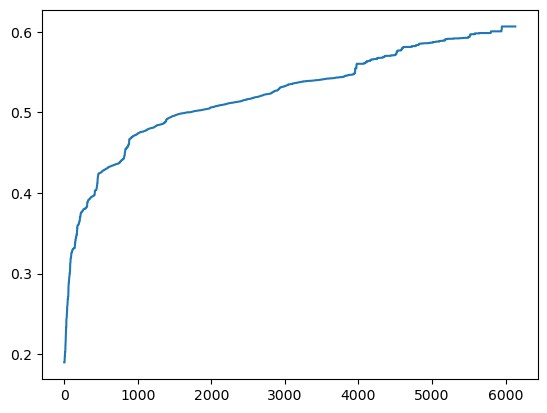

In [109]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [110]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['career_points']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

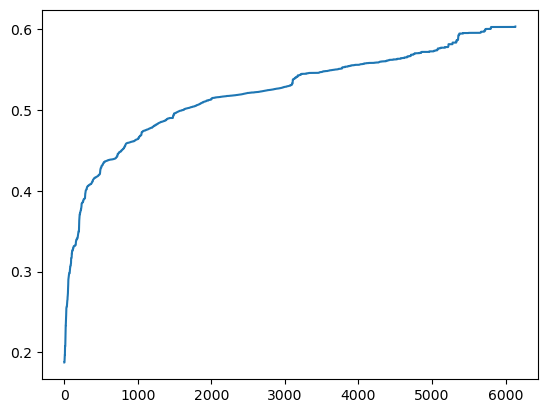

In [111]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [112]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['career_duration(days)']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

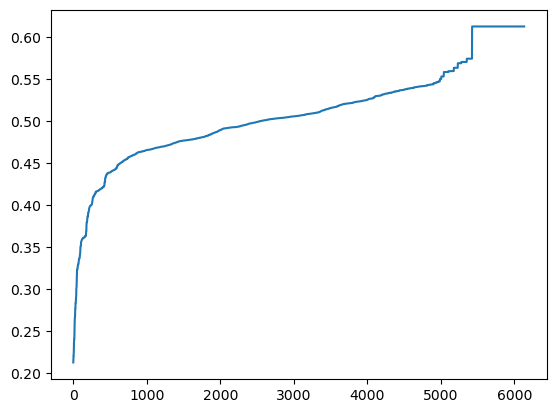

In [113]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [114]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['career_duration(races)']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

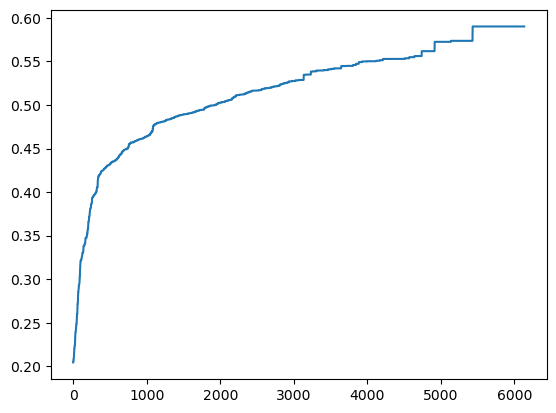

In [115]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [116]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['debut_year']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

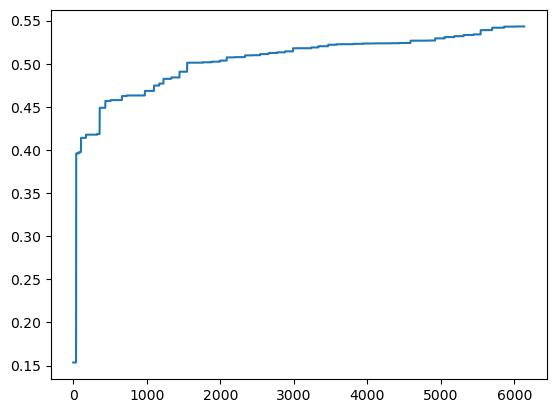

In [117]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

In [118]:
from sklearn.ensemble import IsolationForest

data_only_dataset = cyclists[['avg_pos']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

cyclists.loc[:, "isolation_forest_degree"] = outlier_degrees
cyclists.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

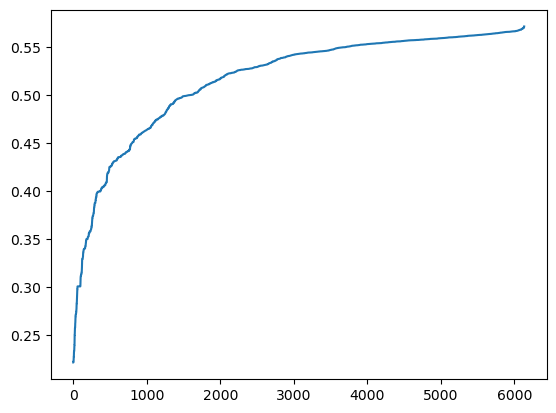

In [119]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

## Races' outlier detection

In [120]:
datasetname = path.join('..', 'dataset', 'races_cleaned.csv')
races = pd.read_csv(datasetname)
races = races.drop(races.columns[0], axis=1)

For the races we use the following features:
- `points` 
- `length`
- `climb_total`
- `startlist_quality`
- `position`
- `cyclist_age`
- `year`

In [121]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['points']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

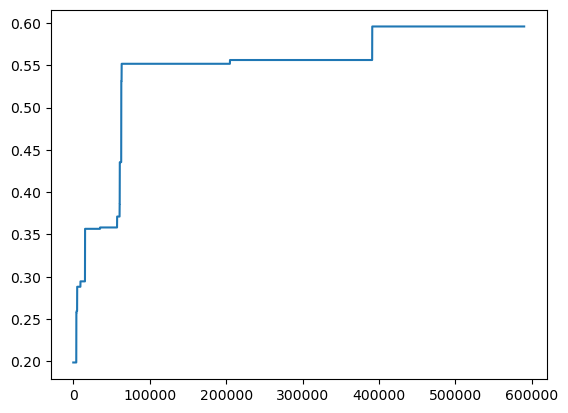

In [122]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [123]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['length']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

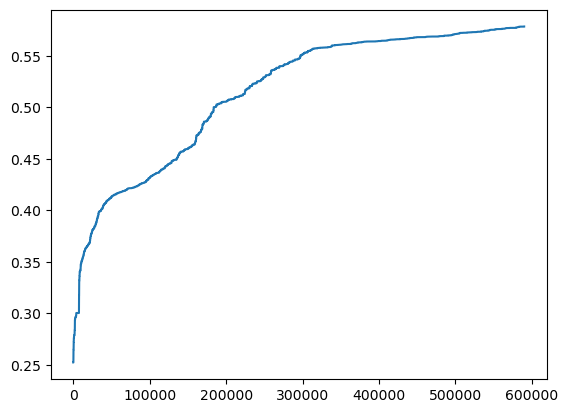

In [124]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [125]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['climb_total']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

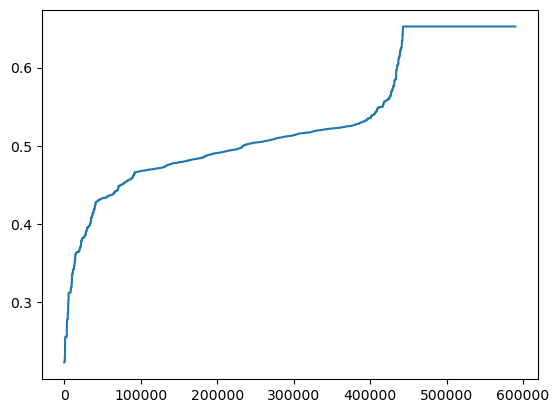

In [126]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [127]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['startlist_quality']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

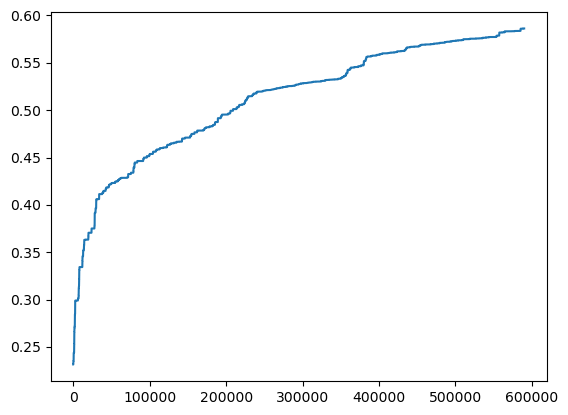

In [128]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [129]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['position']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

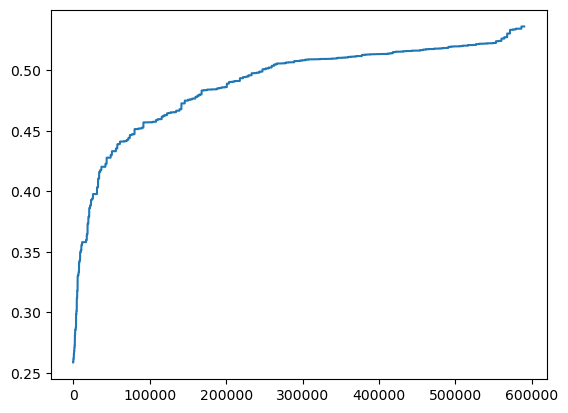

In [130]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

In [131]:
from sklearn.ensemble import IsolationForest

data_only_dataset = races[['cyclist_age']]

max_features = data_only_dataset.shape[1]
algorithm = IsolationForest(max_features=max_features)
algorithm.fit(data_only_dataset)
# the lower, more outliers
outlier_degrees = algorithm.decision_function(data_only_dataset) + 0.5
outlier_scores = 1 - (algorithm.predict(data_only_dataset) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)

races.loc[:, "isolation_forest_degree"] = outlier_degrees
races.loc[:, "isolation_forest_scores"] = outlier_scores

<Axes: >

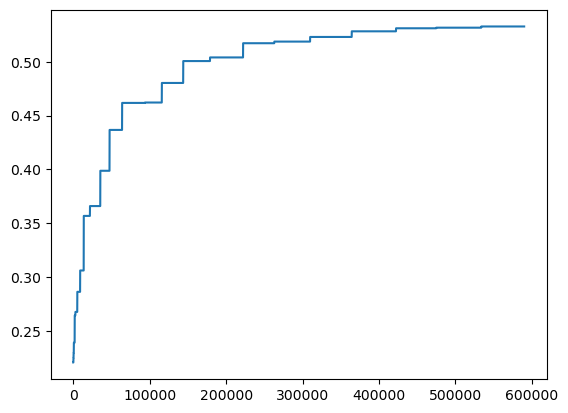

In [132]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

<Axes: >

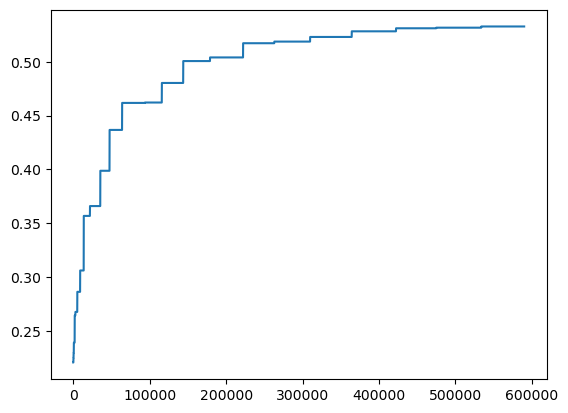

In [133]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

seaborn.lineplot(
    x=range(races.shape[0]),
    y=sorted_outlier_degrees
)

### LOF Algorithm
TBD: choose if we want to use LOF or Isolation Forest

In [134]:
from sklearn.neighbors import LocalOutlierFactor

k = 25
data_only_dataset = cyclists[['weight']]
algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(data_only_dataset)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists.loc[:, "lof_degree"] = outlier_degrees

<Axes: >

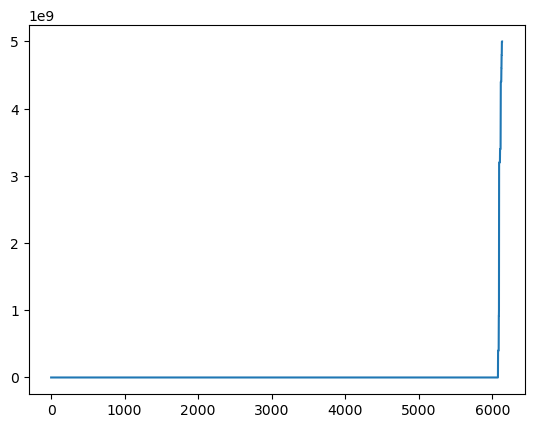

In [135]:
import seaborn
from scipy.spatial.distance import pdist, squareform

sorted_outlier_degrees = sorted(outlier_degrees)

# to achieve comparable degrees among different algorithms,
# we normalize distance-based scores by the maximum possible distance
# distances = squareform(pdist(data_only_dataset.values))
# maximum_possible_radius = distances.max()
# normalization_factor = maximum_possible_radius / k
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### One-class SVM

In [136]:
from sklearn.svm import OneClassSVM


kernel = "rbf"
# kernel = "linear"
# kernel = "poly"
algorithm = OneClassSVM(kernel=kernel)
algorithm.fit(data_only_dataset)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(data_only_dataset)
outlier_distance_scores = algorithm.score_samples(data_only_dataset)

cyclists.loc[:, "oneclass_svm_degree"] = outlier_distance_scores
cyclists.loc[:, "oneclass_svm_degree_binary"] = (outlier_classification_scores  + 1) % 2  # map to {0, 1}

if kernel == "linear":
    support_vectors = data_only_dataset.iloc[algorithm.support_]
    
else:
    support_vectors = None

<Axes: >

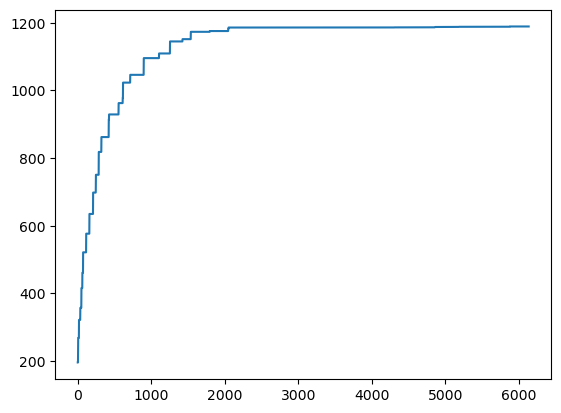

In [137]:
import seaborn
from scipy.spatial.distance import pdist, squareform


sorted_outlier_degrees = sorted(outlier_distance_scores)

# to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
# normalization_factor = sorted_outlier_degrees[-1]
# normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
# dataset_with_outlier_scores.loc[:, "oneclass_svm_degree_normalized"] = outlier_degrees / normalization_factor

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### Gaussian Mixture algorithm

In [138]:
from sklearn.mixture import GaussianMixture
import numpy
import seaborn


k = 5
algorithm = GaussianMixture(n_components=k)
algorithm.fit(data_only_dataset.values)

outlier_degrees_per_normal = algorithm.predict_proba(data_only_dataset.values)
outlier_degrees = outlier_degrees_per_normal.max(axis=1)

cyclists.loc[:, "density_degree"] = outlier_degrees

<Axes: >

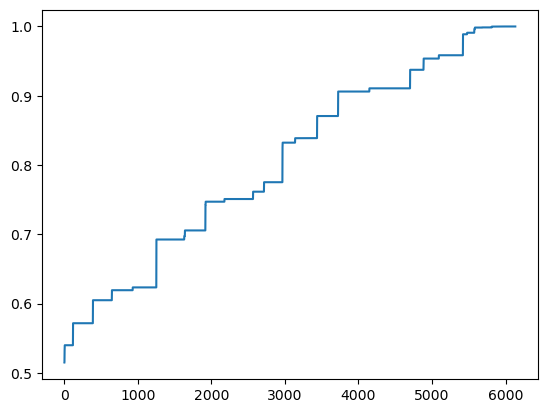

In [139]:
sorted_outlier_degrees = sorted(outlier_degrees)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_degrees)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_degrees
)

### COPOD algorithm

<Axes: >

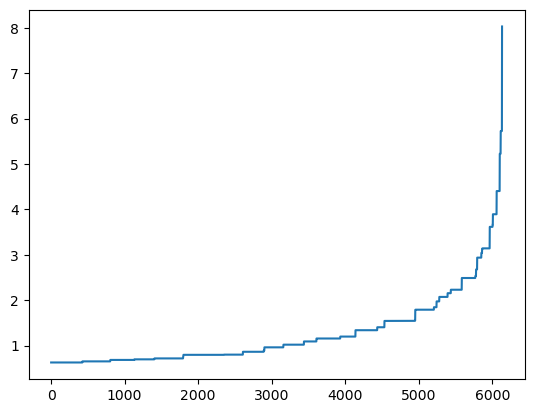

In [140]:
from pyod.models.copod import COPOD  # manifold-based

algorithm = COPOD()
algorithm.fit(data_only_dataset)
outlier_scores = algorithm.decision_function(data_only_dataset)
outlier_labels = algorithm.predict(data_only_dataset)
sorted_outlier_scores = sorted(outlier_scores)
outlier_degrees_cdf = numpy.cumsum(sorted_outlier_scores)

seaborn.lineplot(
    x=range(cyclists.shape[0]),
    y=sorted_outlier_scores
)